In [1]:
import sys
sys.path.append("..")

import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [2]:
E0 = Symbol(u'E0', real = True)
E1 = Symbol(u'E1', real = True)
Ee = Symbol(u'Ee', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

δl = Symbol(u'δl', real = True)
δμ = Symbol(u'δμ', real = True)

Pl = Symbol('Pl', real = True)
Pμ = Symbol('Pμ', real = True)

In [3]:
ham = Hamiltonian(3)
ham.addEnergies([E0, E1, Ee])
ham.addCoupling(1,2,Pl*Ωl, ωl)
ham.addCoupling(0,1,Pμ*Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineStateDetuning(1,2,δl)
ham.defineStateDetuning(0,1,δμ)

In [4]:
from sympy import nsimplify

In [5]:
ham.transformed = nsimplify(ham.transformed)
ham.transformed

Matrix([
[-δl - δμ, -Pμ*Ωμ/2,        0],
[-Pμ*Ωμ/2,      -δl, -Pl*Ωl/2],
[       0, -Pl*Ωl/2,        0]])

In [96]:
Γ32 = Symbol(u'Γ32', real = True)
dis = Dissipator(3)
dis.addDecay(2,1,Γ32/2)
dis.dissipator

Matrix([
[                       0,                        0, -Γ32*ρ₀₂(t)/4],
[                       0,             Γ32*ρ₂₂(t)/2, -Γ32*ρ₁₂(t)/4],
[-Γ32*conjugate(ρ₀₂(t))/4, -Γ32*conjugate(ρ₁₂(t))/4, -Γ32*ρ₂₂(t)/2]])

In [97]:
bloch = BlochEquations(ham.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [98]:
replacements = ((Pl, 1), (Pμ, 1), (δl, 0), (δμ, 0))
steady_state = bloch.solveSteadyStateSymbolic(replacements)

In [100]:
idx = 0
print(list(steady_state.keys())[idx])
steady_state[list(steady_state.keys())[idx]]

ρ₂₂


2.0*Ωl**2/(Γ32**2 + 4.0*Ωl**2 + 4.0*Ωμ**2)

In [40]:
from julia import Main

In [41]:
nprocs = 1

Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../utils/general_ode_functions.jl")
end
""")

print(Main.eval("procs()"))

[1]


In [42]:
polarizations = 'Pl Pμ'.split(' ')

In [43]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
#     print(s, polarizations, str(s) in polarizations)
    if str(s) not in polarizations:
        Main.eval(f"""
                    @everywhere @parameters {str(s)}
                    tmp = 0
                """);
    else:
        Main.eval(f"@everywhere @variables {str(s)}(t)")


diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

In [44]:
Main.eval("""
@everywhere @parameters ωμp ωlp ϕl ϕμ
tmp = 0
""");

In [45]:
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    append!(eqns, [Pl ~ 1])
    append!(eqns, [Pμ ~ 1])
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [46]:
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [47]:
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(1,2):
    y0[_,_] = 1
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [65]:
Main.eval("""
    @everywhere begin
    p = [
    Ωl => 1,
    Ωμ => 1,
    δμ => 0,
    δl => 0,
    Γ32 => 1,
    ωμp => 1,
    ωlp => 1,
    ϕl => 0,
    ϕμ => 0,
    icomplex => im
    ]
    dim = size(ρ_ini)[1]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:dim for idy in 1:dim]
    tmp =0;
end
""");

In [66]:
Main.eval("""
@everywhere begin
    tspan = (0.0, 300.)
    prob = ODEProblem(bloch, u0, tspan, p, jac = true)
end
""");

In [67]:
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");

In [68]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

54.247686702204106

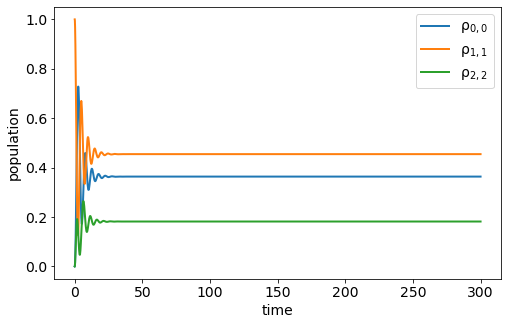

In [69]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real, axis = 0), t_array)

In [58]:
Main.eval("""function Lindblad_rhs!(du, ρ, p, t)
    @inbounds begin
        Ωl = p[1]
        ωpl = p[2]
        δl = p[3]
        ϕl = p[4]
        Ωμ = p[5]
        ωpμ = p[6]
        δμ = p[7]
        ϕμ = p[8]
        Γ32 = p[9]

        Pl = (1+sin(ωpl*t+ϕl))/2
        Pμ = (1+sin(ωpμ*t+ϕμ))/2

        du[1,1] = -1im*(0.5Ωμ*ρ[1, 2]*Pμ - (0.5Ωμ*ρ[2, 1]*Pμ))
        du[1,2] = -1im*(δl*ρ[1, 2] + ρ[1, 2]*(-δl - δμ) + 0.5Ωl*ρ[1, 3]*Pl + 0.5Ωμ*ρ[1, 1]*Pμ - (0.5Ωμ*ρ[2, 2]*Pμ))
        du[1,3] = -1im*(ρ[1, 3]*(-δl - δμ) + 0.5Ωl*ρ[1, 2]*Pl - (0.5Ωμ*ρ[2, 3]*Pμ)) - (0.5Γ32*ρ[1, 3])
        du[2,1] = -1im*(0.5Ωμ*ρ[2, 2]*Pμ - (δl*ρ[2, 1]) - (ρ[2, 1]*(-δl - δμ)) - (0.5Ωl*ρ[3, 1]*Pl) - (0.5Ωμ*ρ[1, 1]*Pμ))
        du[2,2] = Γ32*ρ[3, 3] - (im*(0.5Ωl*ρ[2, 3]*Pl + 0.5Ωμ*ρ[2, 1]*Pμ - (0.5Ωl*ρ[3, 2]*Pl) - (0.5Ωμ*ρ[1, 2]*Pμ)))
        du[2,3] = -1im*(0.5Ωl*ρ[2, 2]*Pl - (δl*ρ[2, 3]) - (0.5Ωl*ρ[3, 3]*Pl) - (0.5Ωμ*ρ[1, 3]*Pμ)) - (0.5Γ32*ρ[2, 3])
        du[3,1] = -1im*(0.5Ωμ*ρ[3, 2]*Pμ - (ρ[3, 1]*(-δl - δμ)) - (0.5Ωl*ρ[2, 1]*Pl)) - (0.5Γ32*ρ[3, 1])
        du[3,2] = -1im*(δl*ρ[3, 2] + 0.5Ωl*ρ[3, 3]*Pl + 0.5Ωμ*ρ[3, 1]*Pμ - (0.5Ωl*ρ[2, 2]*Pl)) - (0.5Γ32*ρ[3, 2])
        du[3,3] = -1im*(0.5Ωl*ρ[3, 2]*Pl - (0.5Ωl*ρ[2, 3]*Pl)) - (Γ32*ρ[3, 3])
    end
    nothing
end    
""")

<PyCall.jlwrap Lindblad_rhs!>

In [59]:
Main.du = np.zeros(Main.ρ_ini.shape, dtype = 'complex')
Main.eval("p1 = [1.,1,0,0,1,1,0,0,1]")
Main.eval("@btime Lindblad_rhs!(du, ρ_ini, p1, 0.0)")

In [23]:
Main.eval("prob1 = ODEProblem(Lindblad_rhs!, ρ_ini, tspan, p1)");

In [24]:
Main.eval("sol1 = solve(prob1, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");

In [25]:
ut = np.array(Main.eval("sol1[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((Main.ρ_ini.shape[0], Main.ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol1.t")

25.895870578577394

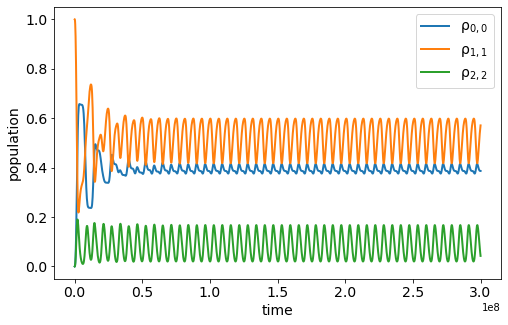

In [26]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real, axis = 0), t_array)

In [27]:
Main.eval("@btime sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");
Main.eval("@btime sol1 = solve(prob1, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");